In [3]:
with open("./data/raw/Hygiene/hygiene.dat.labels") as f:
    labels = [int(l) for l in f.readlines() if l[0].isdigit()]

docs = []
with open("./data/raw/Hygiene/hygiene.dat") as f:
    for i in range(len(labels)):
        docs.append(f.readline().strip("\n"))

with open("./data/processed/train.txt", "w") as f:
    for i, _doc in enumerate(docs[0:int(len(docs)*0.8)]):
        f.write("__label__" + str(labels[i]) + " " + _doc + "\n")

with open("./data/processed/dev.txt", "w") as f:
    for i, _doc in enumerate(docs[int(len(docs)*0.8):int(len(docs)*0.9)]):
        f.write("__label__" + str(labels[i]) + " " + _doc + "\n")
        
with open("./data/processed/test.txt", "w") as f:
    for i, _doc in enumerate(docs[int(len(docs)*0.9):]):
        f.write("__label__" + str(labels[i]) + " " + _doc + "\n")

### For Bert

In [4]:
import pandas as pd

df_bert_train = pd.DataFrame({'user_id':0,
                              'label':labels[0:int(len(docs)*0.8)],
                              'alpha': 0,
                             'text':docs[0:int(len(docs)*0.8)]})
df_bert_train['text'] = df_bert_train['text'].replace(r'\n', ' ', regex=True).replace(r',', ' ', regex=True)

df_bert_dev = pd.DataFrame({'user_id':0,
                            'label':labels[int(len(docs)*0.8):int(len(docs)*0.9)],
                            'alpha': 0,
                           'text':docs[int(len(docs)*0.8):int(len(docs)*0.9)]})
df_bert_dev['text'] = df_bert_dev['text'].replace(r'\n', ' ', regex=True).replace(r',', ' ', regex=True)

df_bert_test = pd.DataFrame({'user_id':0,
                             'label':labels[int(len(docs)*0.9):],
                             'alpha': 0,
                            'text':docs[int(len(docs)*0.9):]})
df_bert_test['text'] = df_bert_test['text'].replace(r'\n', ' ', regex=True).replace(r',', ' ', regex=True)

df_bert_train.to_csv('./data/processed/train.tsv', sep='\t', index=False, header=False)
df_bert_dev.to_csv('./data/processed/dev.tsv', sep='\t', index=False, header=False)
df_bert_test.to_csv('./data/processed/test.tsv', sep='\t', index=False, header=True)

### For FastText

In [48]:
import pandas as pd

train_fasttext = pd.DataFrame()
train_df = pd.read_csv("~/Downloads/dbpedia_csv/train.csv", header=None)

train_fasttext['text'] = train_df.iloc[:,2]
train_fasttext['label'] = ["__label__" + str(i) for i in train_df.iloc[:,0]]
train_fasttext.to_csv("~/Downloads/dbpedia_csv/train_fasttext.csv", header = False, index = False, sep = ' ')

In [49]:
test_fasttext = pd.DataFrame()
test_df = pd.read_csv("~/Downloads/dbpedia_csv/test.csv", header=None)

test_fasttext['text'] = test_df.iloc[:,2]
test_fasttext['label'] = ["__label__" + str(i) for i in test_df.iloc[:,0]]
test_fasttext.to_csv("~/Downloads/dbpedia_csv/test_fasttext.csv", header = False, index = False,  sep = ' ')

In [57]:
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from tqdm import tqdm
import numpy as np
import pandas as pd


stemmer = SnowballStemmer('english')
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    result_stemmed = []
    for token in simple_preprocess(text, min_len = 2):
        result.append(token)
        if token not in STOPWORDS:
            result_stemmed.append(lemmatize_stemming(token))
    
    return (result, result_stemmed)


with open("./data/raw/Hygiene/hygiene.dat.labels") as f:
    LABELS = [int(i) for i in f.readlines()[0:546]]

LABELED_STEMMED_TEXTS = []
with open("./data/raw/Hygiene/hygiene.dat") as f:
    for i in tqdm(range(len(LABELS))):
        _text = f.readline()
        _result, _result_stemmed = preprocess(_text)
        LABELED_STEMMED_TEXTS.append(_result_stemmed)
        
train_text = LABELED_STEMMED_TEXTS[0:400]
train_label = LABELS[0:400]
test_text = LABELED_STEMMED_TEXTS[400:len(LABELS)]
test_label = LABELS[400:len(LABELS)]

100%|████████████████████████████████████████████████████████████████████████████████| 546/546 [00:10<00:00, 52.66it/s]


In [58]:
_dictionary = corpora.Dictionary(train_text)
train_count = [_dictionary.doc2bow(_doc) for _doc in train_text]
test_count = [_dictionary.doc2bow(_doc) for _doc in test_text]

tfidf_model = models.TfidfModel(train_count)
train_tfidf = [_doc for _doc in tfidf_model[train_count]]
test_tfidf = [_doc for _doc in tfidf_model[test_count]]

In [59]:
labeled_train_count = [(dict(_doc), train_label[i]) for i, _doc in enumerate(train_count)]
labeled_test_count = [dict(_doc) for _doc in test_count]

labeled_train_tfidf = [(dict(_doc), train_label[i]) for i, _doc in enumerate(train_tfidf)]
labeled_test_tfidf = [dict(_doc) for _doc in test_tfidf]

In [60]:
from sklearn import metrics
from nltk.classify import NaiveBayesClassifier

NB_classifier_count = NaiveBayesClassifier.train(labeled_train_count)

predictions = NB_classifier_count.classify_many(labeled_test_count)

print(metrics.confusion_matrix(test_label, predictions))
print(metrics.accuracy_score(test_label, predictions),
            metrics.precision_score(test_label, predictions),
            metrics.recall_score(test_label, predictions),
            metrics.f1_score(test_label, predictions))

[[ 5 75]
 [ 1 65]]
0.4794520547945205 0.4642857142857143 0.9848484848484849 0.6310679611650486


In [61]:
from nltk.classify import DecisionTreeClassifier

DT_classifier_count = DecisionTreeClassifier.train(labeled_train_count)
predictions = DT_classifier_count.classify_many(labeled_test_count)

print(metrics.confusion_matrix(test_label, predictions))
print(metrics.accuracy_score(test_label, predictions),
            metrics.precision_score(test_label, predictions),
            metrics.recall_score(test_label, predictions),
            metrics.f1_score(test_label, predictions))

[[52 28]
 [33 33]]
0.5821917808219178 0.5409836065573771 0.5 0.5196850393700788


In [62]:
from nltk.classify.maxent import TypedMaxentFeatureEncoding, MaxentClassifier

encoding = TypedMaxentFeatureEncoding.train(labeled_train_tfidf, 
                                                   count_cutoff=3, 
                                                   alwayson_features=True)
Maxent_classifier_count = MaxentClassifier.train(labeled_train_tfidf, 
                                           bernoulli=False, 
                                           encoding=encoding, 
                                           trace=0)

predictions = Maxent_classifier_count.classify_many(labeled_test_tfidf)

print(metrics.confusion_matrix(test_label, predictions))
print(metrics.accuracy_score(test_label, predictions),
            metrics.precision_score(test_label, predictions),
            metrics.recall_score(test_label, predictions),
            metrics.f1_score(test_label, predictions))

[[ 0 80]
 [ 0 66]]
0.4520547945205479 0.4520547945205479 1.0 0.6226415094339622


In [1]:
from flair.datasets import ClassificationCorpus
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentRNNEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from pathlib import Path

corpus = ClassificationCorpus(Path('./data/processed'), 
                                test_file='test.txt', 
                                dev_file='dev.txt', 
                                train_file='train.txt')


word_embeddings = [WordEmbeddings('glove')
#                    , FlairEmbeddings('news-forward-fast')
#                    , FlairEmbeddings('news-backward-fast')
                  ]

document_embeddings = DocumentRNNEmbeddings (word_embeddings, hidden_size=512, reproject_words=True, reproject_words_dimension=256)
classifier = TextClassifier(document_embeddings, 
                            label_dictionary = corpus.make_label_dictionary(), 
                            multi_label=False)
trainer = ModelTrainer(classifier, corpus)
trainer.train('./data/model', max_epochs=10)
# trainer.train('./data/model',
#               learning_rate=0.1,
#               mini_batch_size=32,
#               anneal_factor=0.5,
#               patience=5,
#               max_epochs=10)

C:\Users\geesi\Anaconda3\envs\dm_cap_py3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


2019-07-20 13:40:33,639 Reading data from data\processed
2019-07-20 13:40:33,639 Train: data\processed\train.txt
2019-07-20 13:40:33,639 Dev: data\processed\dev.txt
2019-07-20 13:40:33,639 Test: data\processed\test.txt
2019-07-20 13:40:33,666 this function is deprecated, use smart_open.open instead
2019-07-20 13:40:51,140 {'1', '0'}
2019-07-20 13:41:04,596 ----------------------------------------------------------------------------------------------------
2019-07-20 13:41:04,604 Evaluation method: MICRO_F1_SCORE
2019-07-20 13:41:08,279 ----------------------------------------------------------------------------------------------------
2019-07-20 13:41:25,189 epoch 1 - iter 0/14 - loss 0.74729067
2019-07-20 13:41:32,328 epoch 1 - iter 1/14 - loss 0.70541766
2019-07-20 13:41:43,841 epoch 1 - iter 2/14 - loss 0.72190150
2019-07-20 13:41:48,872 epoch 1 - iter 3/14 - loss 0.79746288
2019-07-20 13:41:56,365 epoch 1 - iter 4/14 - loss 0.98525941
2019-07-20 13:42:05,013 epoch 1 - iter 5/14 - l

2019-07-20 13:53:36,391 epoch 6 - iter 13/14 - loss 0.69970745
2019-07-20 13:53:37,813 ----------------------------------------------------------------------------------------------------
2019-07-20 13:53:37,813 EPOCH 6 done: loss 0.6997 - lr 0.0500 - bad epochs 0
2019-07-20 13:53:50,656 DEV : loss 0.6826524138450623 - score 0.5818
2019-07-20 13:54:03,256 TEST : loss 0.7131308317184448 - score 0.3818
2019-07-20 13:54:06,878 ----------------------------------------------------------------------------------------------------
2019-07-20 13:54:20,224 epoch 7 - iter 0/14 - loss 0.67469764
2019-07-20 13:54:31,908 epoch 7 - iter 1/14 - loss 0.64981678
2019-07-20 13:54:37,204 epoch 7 - iter 2/14 - loss 0.65919878
2019-07-20 13:54:44,451 epoch 7 - iter 3/14 - loss 0.68572752
2019-07-20 13:54:51,689 epoch 7 - iter 4/14 - loss 0.68351893
2019-07-20 13:54:58,413 epoch 7 - iter 5/14 - loss 0.68709972
2019-07-20 13:55:05,983 epoch 7 - iter 6/14 - loss 0.68481536
2019-07-20 13:55:12,893 epoch 7 - ite

{'test_score': 0.3818,
 'dev_score_history': [0.5818,
  0.4182,
  0.5636,
  0.4909,
  0.5818,
  0.5818,
  0.4727,
  0.5636,
  0.5636,
  0.5273],
 'train_loss_history': [0.8243292186941419,
  0.786785112959998,
  0.7212365652833667,
  0.710352212190628,
  0.7085857221058437,
  0.699707452739988,
  0.6735274280820575,
  0.6784602573939732,
  0.6894024780818394,
  0.6743174706186567],
 'dev_loss_history': [tensor(0.6791, device='cuda:0'),
  tensor(0.7356, device='cuda:0'),
  tensor(0.6841, device='cuda:0'),
  tensor(0.7050, device='cuda:0'),
  tensor(0.6713, device='cuda:0'),
  tensor(0.6827, device='cuda:0'),
  tensor(0.6916, device='cuda:0'),
  tensor(0.6825, device='cuda:0'),
  tensor(0.6807, device='cuda:0'),
  tensor(0.6898, device='cuda:0')]}

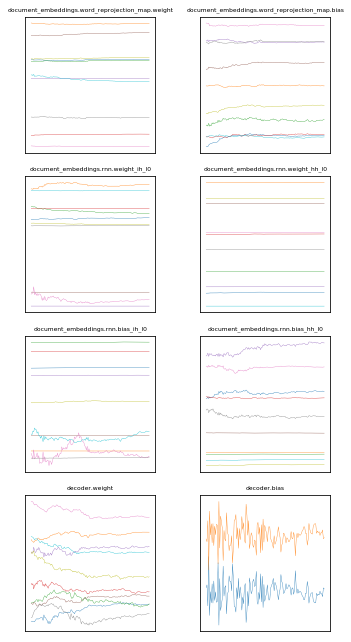

In [6]:
%matplotlib inline

from flair.visual.training_curves import Plotter
plotter = Plotter()
plotter.plot_training_curves('./data/model/loss.tsv')
plotter.plot_weights('./data/model/weights.txt')

In [38]:
from flair.models import TextClassifier
from flair.data import Sentence
from sklearn import metrics

classifier = TextClassifier.load('./data/model/best-model.pt')

test_text = df_bert_test['text']
test_label =  df_bert_test['label']
predictions = []
for _text in test_text:
    sentence = Sentence(_text)
    classifier.predict(sentence)
    predictions.append(int(sentence.labels[0].value))

print(metrics.confusion_matrix(predictions, test_label))
print (metrics.accuracy_score(predictions, test_label),
            metrics.precision_score(predictions, test_label),
            metrics.recall_score(predictions, test_label),
            metrics.f1_score(predictions, test_label))

2019-07-20 15:10:25,165 loading file ./data/model/best-model.pt
[[ 5  5]
 [28 17]]
0.4 0.7727272727272727 0.37777777777777777 0.5074626865671642


In [55]:
predictions = [1 for i in range(len(predictions))]

print(metrics.confusion_matrix(test_label, predictions))
print (metrics.accuracy_score(test_label, predictions),
            metrics.precision_score(test_label, predictions),
            metrics.recall_score(test_label, predictions),
            metrics.f1_score(test_label, predictions))

[[ 0 33]
 [ 0 22]]
0.4 0.4 1.0 0.5714285714285715
